In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
class Encoder(nn.Module):
    
    def __init__(self, latent_dim, pre_latent_fc_dim):
        super().__init__()
        
        # ----- Convolutional layers ----- #
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1), # 28 x 28 x 3 -> 14 x 14 x 8
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), # 14 x 14 x 8 -> 7 x 7 x 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0), # 7 x 7 x 16 -> 3 x 3 x 32
            nn.ReLU(),
        )
        
        # ----- Flatten layer ----- #
        self.flatten = nn.Flatten()
        
        # ----- Fully connected layers ----- #
        self.encoder_fc = nn.Sequential(
            nn.Linear(3*3*32, pre_latent_fc_dim),
            nn.ReLU(),
            nn.Linear(pre_latent_fc_dim, latent_dim), # output layer has no activation
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_fc(x)
        
        return x

In [3]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, pre_latent_fd_dim):
        super().__init__()
        
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, pre_latent_fd_dim),
            nn.ReLU(),
            nn.Linear(pre_latent_fd_dim, 3*3*32),
            nn.ReLU(),
        )
        
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))
        
        self.decoder_cnn = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=0), # 3 x 3 x 32 -> 7 x 7 x 16
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1), # 7 x 7 x 16 -> 14 x 14 x 8
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1), # 14 x 14 x 8 -> 28 x 28 x 1
        )
        
    def forward(self, x):
        x = self.decoder_fc(x)
        x = self.unflatten(x)
        x = self.decoder_cnn(x)
        
        return x

In [4]:
LOSS_FUNCTION = nn.MSELoss()
LR = 1e-3
BATCH_SIZE = 256
EPOCHS = 30

In [5]:
torch.manual_seed(0) # reproducibility

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

data_directory = 'dataset'

train_transforms = transforms.Compose([transforms.ToTensor()])
test_transforms = transforms.Compose([transforms.ToTensor()])

train_dataset = torchvision.datasets.MNIST(data_directory, train=True, download=True, transform=train_transforms)
test_dataset = torchvision.datasets.MNIST(data_directory, train=False, download=True, transform=test_transforms)

data_len = len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(data_len*0.8), int(data_len*0.2)])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

Selected device: cuda


In [6]:
encoder = Encoder(latent_dim=3, pre_latent_fc_dim=128).to(device)
decoder = Decoder(latent_dim=3, pre_latent_fd_dim=128).to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=LR, weight_decay=1e-5)

In [7]:
def train_epoch():
    encoder.train()
    decoder.train()
    
    train_loss = []
    
    for batch_index, (images, _) in enumerate(train_loader): # _ is for labels as we don't need them since AE is unsupervised
        images = images.to(device)
        
        optimizer.zero_grad()
        
        latent = encoder(images)
        output = decoder(latent)
        
        loss = LOSS_FUNCTION(output, images)
        
        optimizer.zero_grad()
        loss.backward()        
        optimizer.step()
        
        #print('\t partial train loss: ', loss.item())
        
        train_loss.append(loss.detach().cpu().item())

    return np.mean(train_loss)

In [8]:
def test_epoch():
    encoder.eval()
    decoder.eval()
    
    with torch.no_grad():
        outputs = []
        originals = []
        
        for batch_index, (images, _) in enumerate(test_loader):
            images = images.to(device)
            
            latent = encoder(images)
            output = decoder(latent)
            
            outputs.append(output)
            originals.append(images)

        outputs = torch.cat(outputs, dim=0)
        originals = torch.cat(originals, dim=0)
        
        val_loss = LOSS_FUNCTION(outputs, originals)
        
    return val_loss.item()

In [9]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[t_idx[i]][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()
        with torch.no_grad():
            rec_img  = decoder(encoder(img))
        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Original images')
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
    plt.show()   

EPOCH 1/30 	 train loss 0.10035239274990052 	 val loss 0.057126909494400024
EPOCH 2/30 	 train loss 0.052323581155468805 	 val loss 0.04891291260719299
EPOCH 3/30 	 train loss 0.04715755896920219 	 val loss 0.04506486654281616
EPOCH 4/30 	 train loss 0.04378715963994569 	 val loss 0.04249320551753044
EPOCH 5/30 	 train loss 0.041771077233901686 	 val loss 0.04087140038609505
EPOCH 6/30 	 train loss 0.04047613291743588 	 val loss 0.040029581636190414
EPOCH 7/30 	 train loss 0.03954652112294385 	 val loss 0.03905811905860901
EPOCH 8/30 	 train loss 0.03887767685537643 	 val loss 0.0385681688785553
EPOCH 9/30 	 train loss 0.03837681898569807 	 val loss 0.037992000579833984
EPOCH 10/30 	 train loss 0.03788395703552251 	 val loss 0.03783639147877693


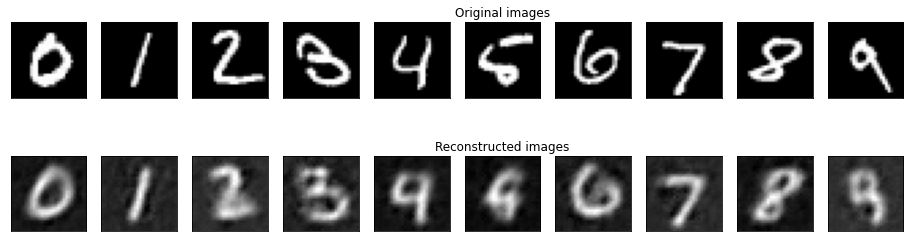

EPOCH 11/30 	 train loss 0.037485398490853764 	 val loss 0.03731158748269081
EPOCH 12/30 	 train loss 0.03716874441647149 	 val loss 0.037082552909851074
EPOCH 13/30 	 train loss 0.036837160369341676 	 val loss 0.036863356828689575
EPOCH 14/30 	 train loss 0.036611998433920934 	 val loss 0.03667008876800537
EPOCH 15/30 	 train loss 0.036306115124929456 	 val loss 0.03630658611655235
EPOCH 16/30 	 train loss 0.03608416835282077 	 val loss 0.03618048503994942
EPOCH 17/30 	 train loss 0.03589162212657802 	 val loss 0.03585873171687126
EPOCH 18/30 	 train loss 0.035668326799381284 	 val loss 0.03554524853825569
EPOCH 19/30 	 train loss 0.0354689835432045 	 val loss 0.03556906804442406
EPOCH 20/30 	 train loss 0.03526696935296059 	 val loss 0.03536113724112511


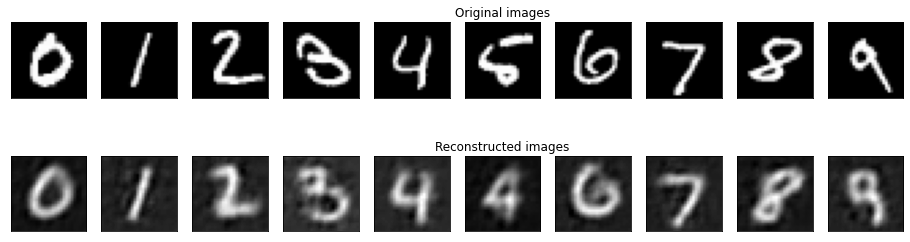

EPOCH 21/30 	 train loss 0.0351335799836732 	 val loss 0.03535373508930206
EPOCH 22/30 	 train loss 0.034962452948093414 	 val loss 0.035067349672317505
EPOCH 23/30 	 train loss 0.03484212710185254 	 val loss 0.03491627797484398
EPOCH 24/30 	 train loss 0.034711484262283814 	 val loss 0.03496508300304413
EPOCH 25/30 	 train loss 0.03455513900026996 	 val loss 0.034653324633836746
EPOCH 26/30 	 train loss 0.034472350764306305 	 val loss 0.03468625620007515
EPOCH 27/30 	 train loss 0.03433720951780994 	 val loss 0.0345388762652874
EPOCH 28/30 	 train loss 0.034209179077693753 	 val loss 0.03451911360025406
EPOCH 29/30 	 train loss 0.03412974465321353 	 val loss 0.03436866030097008
EPOCH 30/30 	 train loss 0.03399486162085483 	 val loss 0.0343521349132061


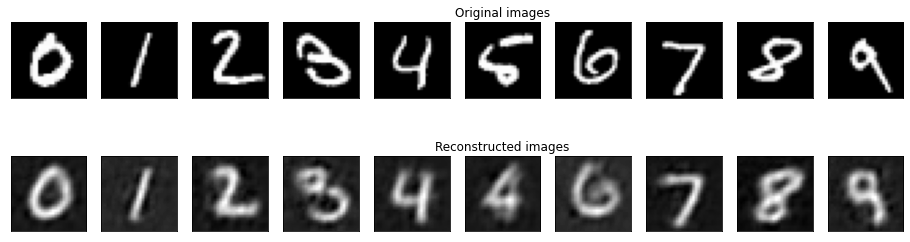

In [10]:
loss = {'train_loss':[],'val_loss':[]}

for epoch in range(EPOCHS):
    train_loss = train_epoch()
    val_loss = test_epoch()
    
    print(f'EPOCH {epoch + 1}/{EPOCHS} \t train loss {train_loss} \t val loss {val_loss}')
    
    loss['train_loss'].append(train_loss)
    loss['val_loss'].append(val_loss)
    
    if (epoch+1) % 10 == 0:
        plot_ae_outputs(encoder,decoder, n=10)

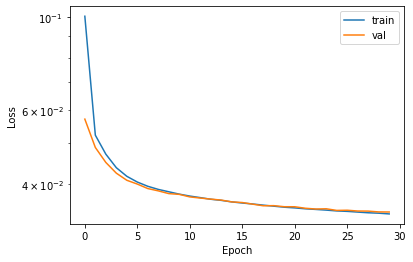

In [11]:
plt.semilogy(loss['train_loss'], label='train')
plt.semilogy(loss['val_loss'], label='val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([ 0.1602, -0.4928, -0.3725])
tensor([0.8271, 0.7098, 0.7106])


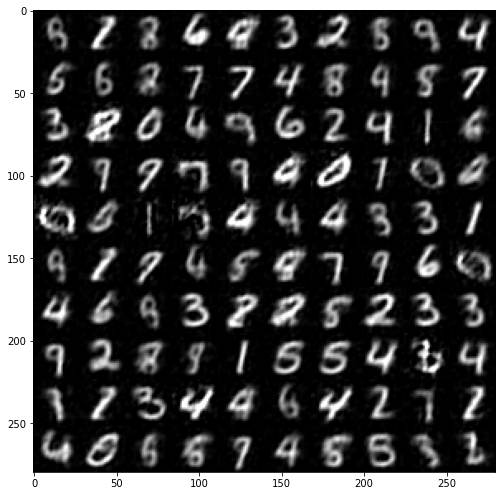

In [59]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # resphae to 28 x 28 x 1 and plot

encoder.eval()
decoder.eval()

with torch.no_grad():
    images, labels = next(iter(test_loader))
    images = images.to(device)
    latent = encoder(images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, 3)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    output = decoder(latent)
    output = output.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(output[:100],10,0))
    plt.show()

In [26]:
encoded_images = []
encoded_labels = []
for image in test_dataset:
    
    encoded_labels.append(image[1])
    
    image = image[0].unsqueeze(0) # generate batch dimension
    image = image.to(device)
    latent = encoder(image).flatten().cpu().detach().numpy() # generate latent
    
    encoded_images.append(latent)

encoded_images = np.array(encoded_images)

In [28]:
encoded_images[:,0]

array([ 0.4034184 , -1.0291665 , -0.8032088 , ...,  0.05852003,
       -1.4665284 ,  1.393723  ], dtype=float32)

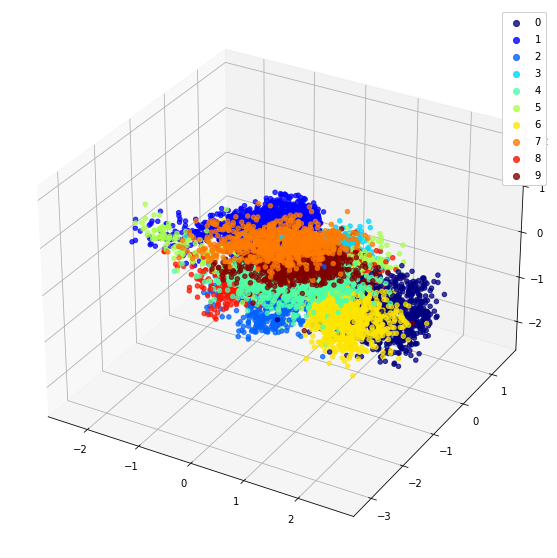

In [50]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(projection='3d')

scatter = ax.scatter(encoded_images[:,0], encoded_images[:,1], encoded_images[:,2], c=encoded_labels, cmap='jet', alpha=0.75)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)

plt.show()

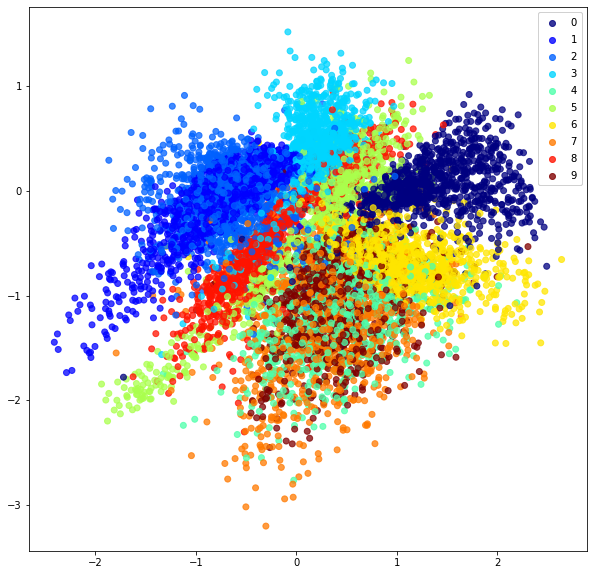

In [57]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

scatter = ax.scatter(encoded_images[:, 0], encoded_images[:, 1], c=encoded_labels, cmap='jet', alpha=0.75)
legend = ax.legend(*scatter.legend_elements())
ax.add_artist(legend)
plt.show()